# Line Following Lab

As described in the presentation, this lab will be all about line following. But, before we can follow lines, we need to write the code to do the image masking necessary to find the lines.

First, we have included some helper functions below just to do some of the very simple tasks involving the camera. We ask that you use these for this notebook as using the underlying libraries incorrectly can cause the camera to become innaccessible until it is restarted. When you are using the car you will use the racecar_core equivalent of take_photo and again will not need to use opencv.

In [2]:
# ROS imports

import sys
sys.path.append("../../library")
import racecar_core

In [3]:
# Init ROS node
import rospy
rospy.init_node("notebook")
rc = racecar_core.Racecar()

>> Entering default drive mode
>> Racecar initialization successful
>> Controlls:
     START button = run your program
     BACK button = enter default drive mode
     BACK + START buttons simultaneously = exit the program
     CTRL + Z on keyboard = force quit the program


In [4]:
# Helper Functions

def crop(image, top_left, bottom_right):
    '''
    image: an image (these are stored as arrays, top left is (0,0))
    top_left: a pair of numbers representing the top left coordinate
    bottom_right: a pair of numbers representing the bottom right coordinate

    Helper function to make cropping images easier
    
    returns: a cropped version of the image
    '''
    x1, y1 = top_left
    x2, y2 = bottom_right
    return image[x1:x2,y1:y2]

import cv2 as cv

def take_photo():
    '''
    Takes enough photos to ensure the camera has had time to bootup
    
    returns: A photo from the camera
    '''
    return rc.camera._get_image_async()
    
import matplotlib.pyplot as plt

def display_photo(image):
    '''
    image: an image
    
    Displays image
    
    returns: nothing
    '''
    plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))
    plt.show()

Now, let's take a photo to see what the car can see!

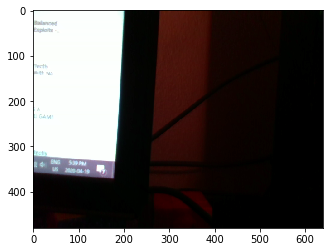

In [5]:
image = take_photo()
display_photo(image)

## Masks

We can see the cone and describe where it is, but the computer can't yet, so let's work on that. We are going to be using a technique that's called a color mask. We describe to the computer a range of color values we care about, and then find the parts of the image that have those colors.

Usually, computers store colors as a set of three numbers describing the amount of blue, green, and red (BGR). But for the task we are going to do, it's easier to think about a color in terms of it's hue, saturation, and value (HSV).

Hue here refers to what color it is, saturation refers to how intense the color is, and value refers to how dark or light the color is.

We reccomend copying the images taken by the camera to your computer (right-click > copy) and using whatever image editing software is on your computer (paint, gimp, etc.) to see what different colors look like in HSV.

We reccomend looking to the openCV documentation for specifics on how to do the different tasks. In particular, we have suggested a few functions we think will be helpful, lookup how to use them here: https://docs.opencv.org/trunk/index.html

In [ ]:
import cv2
import numpy as np

def get_mask(image, hsv_low, hsv_high):
    '''
    image: an image
    hsv_low: three numbers representing the minimal hue, saturation, and value
    hsv_high: three numbers representing the maximal hue, saturation, and value
    
    Using the ranges provided, converts the image to the HSV format then finds what in the image is in the range.

    returns: an array representing where in the image was in the range (the mask)
    '''
    hsv_low = np.array(hsv_low)
    hsv_high = np.array(hsv_high)
    
    #TODO: use the cvtColor function to switch our BGR colors to HSV colors
    
    #TODO: use the inRange function to highlight areas in the correct range
    
    return mask

def cvt_mask_to_image(mask):
    '''
    mask: an image mask
    
    Takes the mask (which is just a 2D array) and adds color channels
    so that it can be displayed easily given our existing infrastructure
    
    returns: a black an white image that is white where the mask is present
    '''
    height, width = mask.shape
    blank_image = np.ones((height, width, 3), dtype=np.uint8)*255
    mask_image = cv2.bitwise_and(blank_image, blank_image, mask=mask)
    
    return mask_image

Now lets see what this looks like, test out different ranges for your Hue, Saturation, and Value? Which ones seem to matter the most?

In [ ]:
mask = get_mask(image,(0,0,0),(255,255,255))
# This mask will capture everything in the image, can we refine that?

mask_image = cvt_mask_to_image(mask)
display_photo(mask_image)

We can even use this mask as a filter to our original image to get a better look at how effective our mask is.

In [ ]:
mask_image_color = cv2.bitwise_and(image, image, mask=mask)
display_photo(mask_image_color)

## Contours

The next step in our process is to find the outline of our object so that we can eventually find it's center. Thankfully there are prebuilt functions for doing this, we just have to use them.

In [ ]:
import cv2
import matplotlib.pyplot as plt

def get_contour(mask):
    '''
    mask: an image mask
    
    Get's the largest contour if it exists, else returns None
    
    returns: a contour
    '''
    MIN_CONTOUR_SIZE = 30
    # Normally we would have you look this up
    # But we are using an old version of the library so the documentation is wrong
    _,contours,_ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = list()
    for contour in contours:
        #TODO: check if the contour is large enough, then add it to the end of our list
        #The contourArea function might be helpful here
    
    if len(large_contours) == 0: return None
    #TODO: If we get to this step we have at least one large contour, return it.
    
def draw_contour(image, contour):
    '''
    image: an image
    contour: an image contour
    
    Helper function to draw a contour in green on an image and display it
    
    returns: an image
    '''
    return cv2.drawContours(np.copy(image), [contour], 0, (0,255,0), 3)

Lets test out what you just wrote! Run the code below to draw the largest contour based on our image mask from above onto our original image. This should outline your cone! It's okay if it's not perfect, but it needs to capture where the cone is on your screen.

In [ ]:
display_photo(draw_contour(image, get_contour(mask)))

Now, we want to find the middle of the cone from this contour, as this will help us to follow lines later on. The code below is written for you because you aren't expected to be able to replicate it on your own, but we will still describe what it means.

We are finding what are called "Moments" of the contour. This is just math speak for certain information summarising the contour. For example $M['m00']$ is just how big the contour is, or it's area (we used a different function to get the same information earlier). $M['m10']$ is a sum of how far to the right each point is, over all points, and $M['m01']$ is the same, but how far down. So if a point inside of our contour has position $(3,5)$, it would contribute 3 to the first sum and 5 to the second. Thats why $M['m10']/M['m00']$ gives us the <em>average</em> horizontal position of the contour, and $M['m01']/M['m00']$ gives us the <em>average</em> vertical position, and so we have the middle.

In [ ]:
def find_center(contour):
    '''
    contour: an image contour
    
    Find the center of the contour
    
    returns: an integer coordinate
    '''
    M = cv2.moments(contour)
    if M['m00'] == 0: # No pixels
        return None
    contour_center_horizontal = M['m10']/M['m00']
    contour_center_vertical = M['m01']/M['m00']
    return (int(contour_center_horizontal), int(contour_center_vertical))

def draw_dot(image, center):
    '''
    image: an array representing an image
    center: an integer 
    
    Helper function to draw an image with a blue dot in a specific location
    
    returns: an image
    '''
    return cv2.circle(np.copy(image), center, 2, (255,0,0), 2)

Lets see if it makes sense, we draw our dot on the image.

In [ ]:
display_photo(draw_dot(image, find_center(get_contour(mask))))

And Now we'll put them both together

In [ ]:
contour = get_contour(mask)
display_photo(draw_dot(draw_contour(image, contour),find_center(contour)))

And that's it! You are ready to tackle your line following lab! Take what you learned above and apply it to following the line. Don't forget to test for things like camera offset when you are figuring out your robot.

We recomend that you use this notebook to figure out what color mask(s) work well for the color(s) you are trying to follow. Feel free to ask us for some tape and setup your own lines to test on the ground or out in the hall.

If you finish early, think about how you might have your car follow multiple colors, or prioritize some colors over others.

Don't be afraid to ask questions, good luck!